1. Variable 	Definition
2. id 	Unique ID for the customer
3. Gender 	Gender of the customer
4. Age 	Age of the customer
5. Driving_License 	0 : Customer does not have DL, 1 : Customer already has DL
6. Region_Code 	Unique code for the region of the customer
7. Previously_Insured 	1 : Customer already has Vehicle Insurance, 0 : Customer doesn't have Vehicle Insurance
8. Vehicle_Age 	Age of the Vehicle
9. Vehicle_Damage 	1 : Customer got his/her vehicle damaged in the past. 0 : Customer didn't get his/her vehicle damaged in the past.
10. Annual_Premium 	The amount customer needs to pay as premium in the year
11. PolicySalesChannel 	Anonymized Code for the channel of outreaching to the customer ie. Different Agents, Over Mail, Over Phone, In Person, etc.
12. Vintage 	Number of Days, Customer has been associated with the company
13. Response 	1 : Customer is interested, 0 : Customer is not interested

In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import  cross_val_score,KFold
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier,StackingClassifier
from xgboost import XGBClassifier
warnings.filterwarnings("ignore")

## Importing Data

In [3]:
df=pd.read_csv('train.csv')
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [4]:
df.shape #inspecting rows and columns

(381109, 12)

In [5]:
df.info() #checking datatypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


There are  9 numeric variables and 3 categorical variables in the data.

## EDA

In [6]:
df.describe()

,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000
mean,190555.000000,38.822584,0.997869,26.388807,0.458210,30564.389581,112.034295,154.347397,0.122563
std,110016.836208,15.511611,0.046110,13.229888,0.498251,17213.155057,54.203995,83.671304,0.327936
min,1.000000,20.000000,0.000000,0.000000,0.000000,2630.000000,1.000000,10.000000,0.000000
25%,95278.000000,25.000000,1.000000,15.000000,0.000000,24405.000000,29.000000,82.000000,0.000000
50%,190555.000000,36.000000,1.000000,28.000000,0.000000,31669.000000,133.000000,154.000000,0.000000
75%,285832.000000,49.000000,1.000000,35.000000,1.000000,39400.000000,152.000000,227.000000,0.000000
max,381109.000000,85.000000,1.000000,52.000000,1.000000,540165.000000,163.000000,299.000000,1.000000


1. *The average 'age' of customer falls between 38-39.*
2. *The maximum 'age' of customer is '85' which indicates there may be outliers in the column.*
3. *The maximum 'Annual_Premium' amount is '5,40,165' which is too far from third quantile indicating potential outliers in the column.*

In [7]:
df.describe(include='object')

,Gender,Vehicle_Age,Vehicle_Damage
count,381109,381109,381109
unique,2,3,2
top,Male,1-2 Year,Yes
freq,206089,200316,192413


**Referring to the data description,**
1. *'Male' gender seems to be more interested in getting insurance policies than 'Female'.*
2. *More than 99% of the customers have Driving License.*
3. *Most of the policy holders are new customers.*
4. *Approximately 85% of the customers are not interested in getting vehicle insurance.*

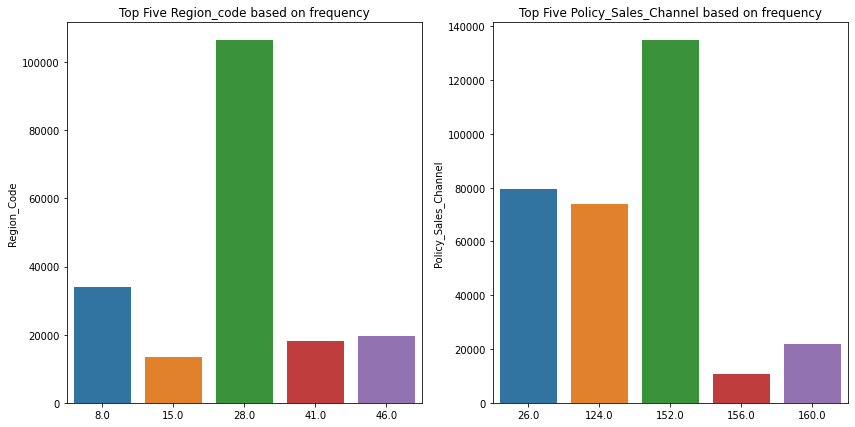

In [8]:
top_five_reg=df['Region_Code'].value_counts().head(5)
top_five_chan=df['Policy_Sales_Channel'].value_counts().head(5)
fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(14,7))
sns.barplot(x=top_five_reg.index,y=top_five_reg,ax=ax[0])
ax[0].set_title('Top Five Region_code based on frequency')
sns.barplot(x=top_five_chan.index,y=top_five_chan,ax=ax[1])
ax[1].set_title('Top Five Policy_Sales_Channel based on frequency')
plt.show()

In [9]:
#calculating percentage of customers from top 5 regions
df['Region_Code'].value_counts(ascending=False).head(5)/len(df)*100

28.0    27.922458
8.0      8.889058
46.0     5.181982
41.0     4.792067
15.0     3.491914
Name: Region_Code, dtype: float64

In [10]:
#calculating percentage of customers for top five channel
df['Policy_Sales_Channel'].value_counts(ascending=False).head(5)/len(df)*100

152.0    35.366260
26.0     20.912652
124.0    19.415705
160.0     5.714638
156.0     2.797362
Name: Policy_Sales_Channel, dtype: float64

* *Nearly 28% of the customers are from region_code '28' which is remarkable given that next highest is region_code '8' with 8.88% of the customers.*
* *55% of the customers  are represented by channnel 152 and 26*

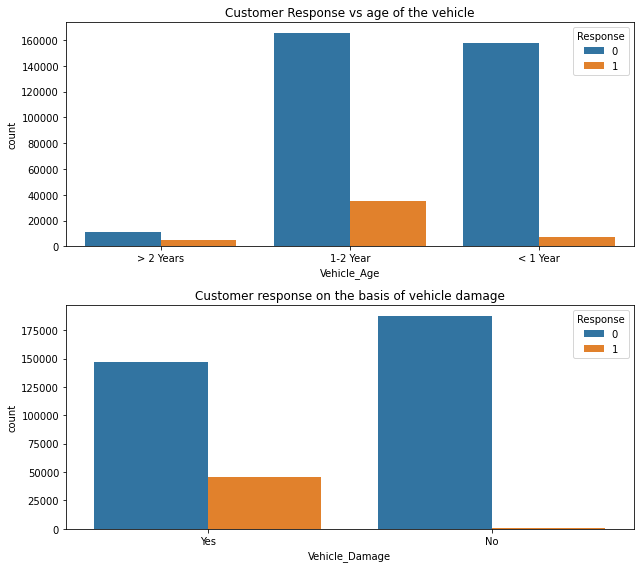

In [11]:
fig,ax=plt.subplots(nrows=2,ncols=1,figsize=(9,8))
sns.countplot(x='Vehicle_Age',hue='Response',data=df,ax=ax[0])
ax[0].set_title('Customer Response vs age of the vehicle')
sns.countplot(x='Vehicle_Damage',hue='Response',data=df,ax=ax[1])
ax[1].set_title('Customer response on the basis of vehicle damage')
plt.tight_layout()
plt.show()

1. *Vehicles between 1-2 years age are getting more number of vehicle insurance than the other two categories*
2. *Customers are prone to apply vehicle insurance if their vehicle is damaged which is obvious from the second plot.*

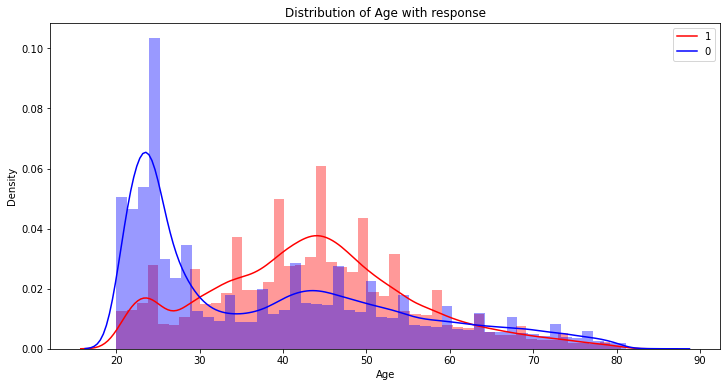

In [12]:
plt.figure(figsize=(12,6))
sns.distplot(df[df['Response']==1]['Age'],color='red')
sns.distplot(df[df['Response']==0]['Age'],color='blue')
plt.title('Distribution of Age with response')
plt.legend([1,0])
plt.show()

**From the above plot,**
* it is clear that most customers between age 30 to 60 are more interested in buying vehicle insurance.
* Also customers with age less than 30 are more likely to reject vehicle insurance.
* One of the reason can be that customers less than 30 may not be financially stable like customer above age 30.

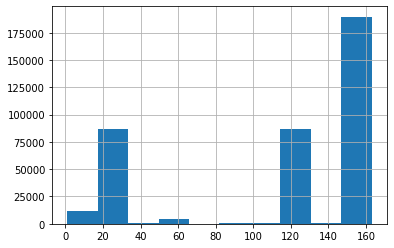

In [13]:
df['Policy_Sales_Channel'].hist() # histogram of Sales_Policy_Channel
plt.show()

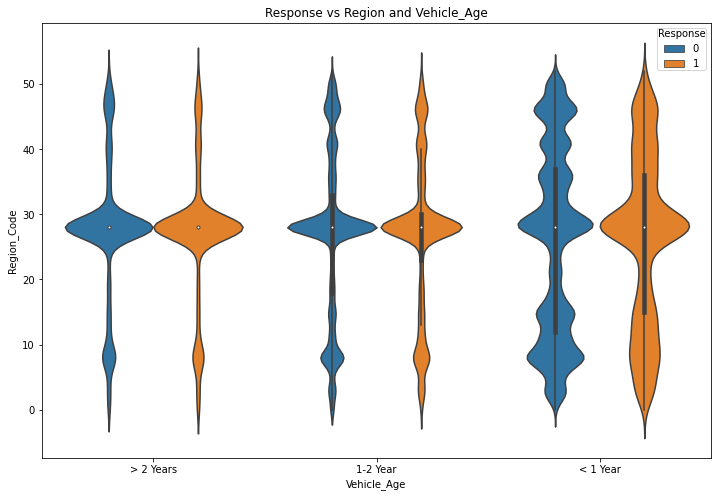

In [14]:
plt.figure(figsize=(12,8))
sns.violinplot(x='Vehicle_Age',y='Region_Code',hue='Response',data=df)
plt.title('Response vs Region and Vehicle_Age')
plt.legend(title='Response',borderpad =0.08)
plt.show()

**Most of the customers from most of the regions have vehicle aged less than 1 year.**


# Outlier Treatment

In [15]:
df_num=df.select_dtypes(include=np.number)

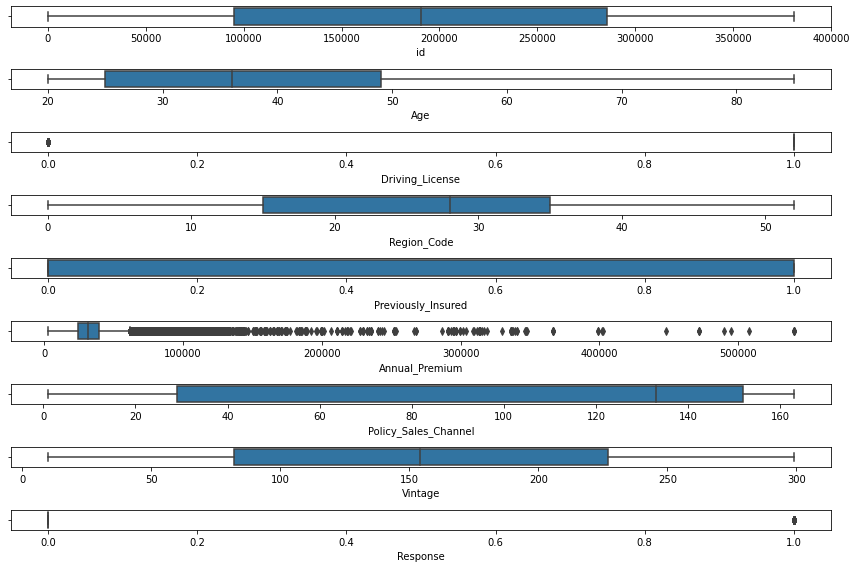

In [16]:
fig,ax=plt.subplots(len(df_num.columns),figsize=(12,8))
for i in range(len(df_num.columns)):
    sns.boxplot(df_num.iloc[:,i],ax=ax[i])
    plt.tight_layout()

<AxesSubplot:xlabel='Annual_Premium'>

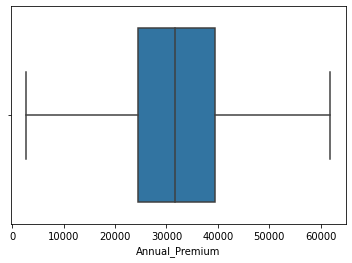

In [17]:
q1=df['Annual_Premium'].quantile(0.25)
q3=df['Annual_Premium'].quantile(0.75)
iqr=q3-q1
ul=q3+1.5*iqr
ll=q1-1.5*iqr
uc=df['Annual_Premium'].quantile(0.95)
lc=df['Annual_Premium'].quantile(0.05)
for i in df['Annual_Premium'].index:
        if df['Annual_Premium'].loc[i]>ul:
            df['Annual_Premium'].loc[i]=uc
        if df['Annual_Premium'].loc[i]<ll:
             df['Annual_Premium'].loc[i]=lc
sns.boxplot(df['Annual_Premium'])

## Data Preprocessing

In [18]:
df['Response'].value_counts() 

0    334399
1     46710
Name: Response, dtype: int64

In [19]:
df['Policy_Sales_Channel'].nunique()

155

In [20]:
#frequency encoding Policy_Sales_Channel
channel=df['Policy_Sales_Channel'].value_counts()/len(df)*100
df['Policy_Sales_Channel']=df['Policy_Sales_Channel'].map(channel)

In [21]:
#frequency encoding Region_Code
region=df['Region_Code'].value_counts()/len(df)*100
df['Region_Code']=df['Region_Code'].map(region)

In [22]:
df['Response'].value_counts()

0    334399
1     46710
Name: Response, dtype: int64

**The number for Response '1' is very low comparing to Response '0',leading to imbalance in classes of target variable.**

In [23]:
x=df.drop('Response',axis=1)
y=df['Response']

In [24]:
x=pd.get_dummies(x,drop_first=True)#encoding categorical variables
x=x.drop('id',axis=1)

In [25]:
x.head(2)

,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Gender_Male,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years,Vehicle_Damage_Yes
0,44,1,27.922458,0,40454.0,20.912652,217,1,0,1,1
1,76,1,2.427390,0,33536.0,20.912652,183,1,0,0,0


## Smote Oversampling

In [26]:
smote=SMOTE(sampling_strategy=0.4)#sampling strategy '0.4' increases minority class to 40% of the majority class

In [27]:
x_sm,y_sm=smote.fit_resample(x,y)#fitting SMOTE model

In [28]:
df_sm = pd.DataFrame(x_sm,columns=x.columns)
df_sm['Response']=y_sm
df_sm.head()#inspecting oversampled dataframe

,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Gender_Male,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years,Vehicle_Damage_Yes,Response
0,44,1,27.922458,0,40454.0,20.912652,217,1,0,1,1,1
1,76,1,2.427390,0,33536.0,20.912652,183,1,0,0,0,0
2,47,1,27.922458,0,38294.0,20.912652,27,1,0,1,1,1
3,21,1,2.422404,1,28619.0,35.366260,203,1,1,0,0,0
4,29,1,4.792067,1,27496.0,35.366260,39,0,1,0,0,0


In [29]:
df_sm.shape#no of records have been increased

(468158, 12)

In [30]:
df_sm['Response'].value_counts()

0    334399
1    133759
Name: Response, dtype: int64

*Here we can see increase in minority class to  40% of majority class.*

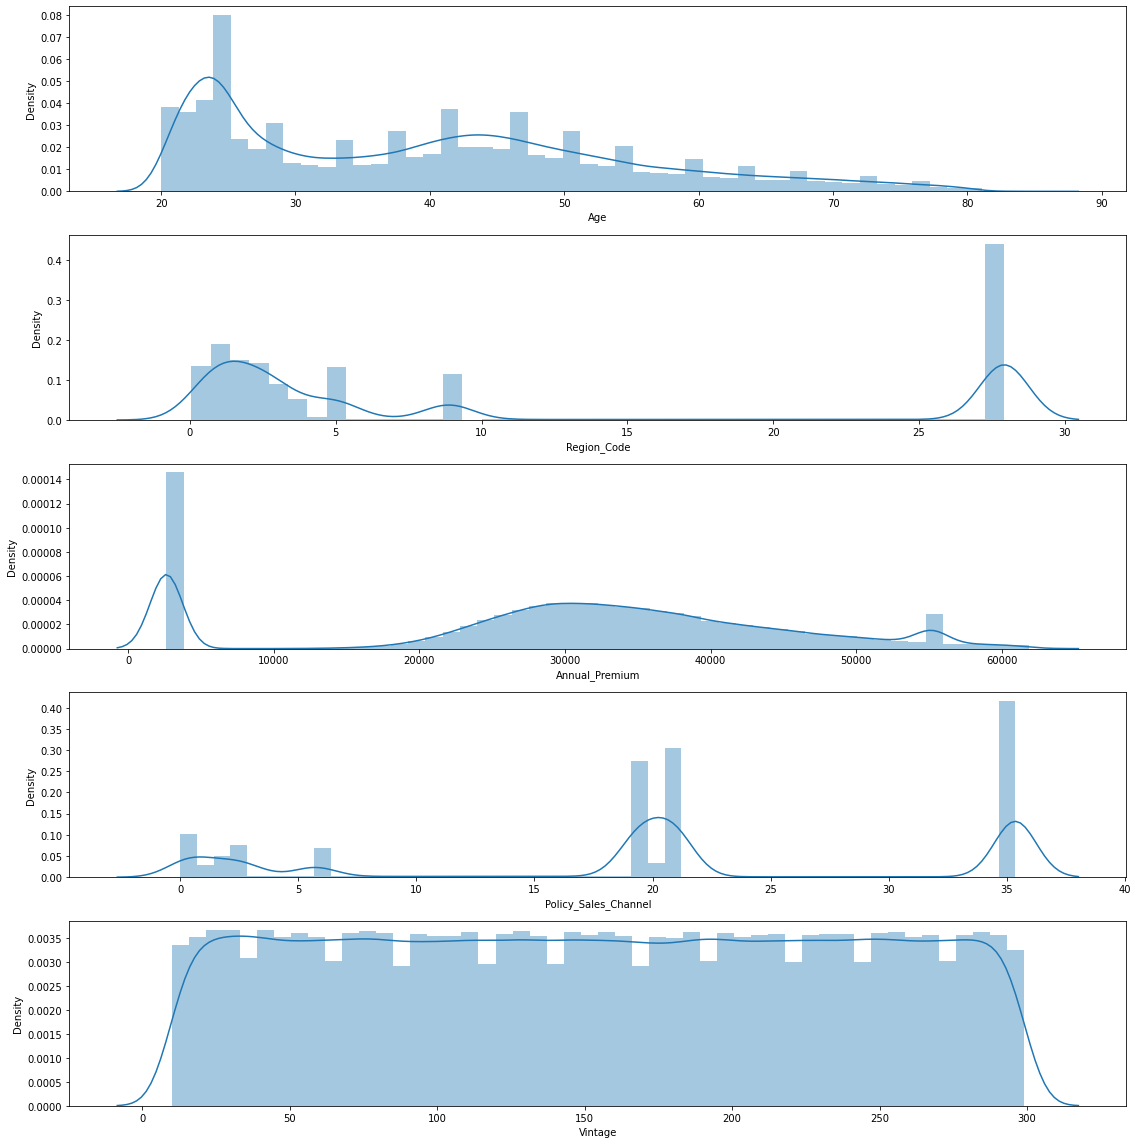

In [31]:
fig,ax=plt.subplots(5,figsize=(16,16))
sns.distplot(df_sm['Age'],ax=ax[0])
sns.distplot(df_sm['Region_Code'],ax=ax[1])
sns.distplot(df_sm['Annual_Premium'],ax=ax[2])
sns.distplot(df_sm['Policy_Sales_Channel'],ax=ax[3])
sns.distplot(df_sm['Vintage'],ax=ax[4])
plt.tight_layout()
plt.show()#checking distribution of the oversampled data

In [32]:
df_sm.skew()

Age                       0.575620
Driving_License         -22.297399
Region_Code               0.736643
Previously_Insured        0.525179
Annual_Premium           -0.475200
Policy_Sales_Channel     -0.252400
Vintage                   0.002350
Gender_Male              -0.046698
Vehicle_Age_< 1 Year      0.574956
Vehicle_Age_> 2 Years     4.886528
Vehicle_Damage_Yes       -0.365393
Response                  0.948691
dtype: float64

**Scaling Data**

In [33]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
ss=StandardScaler()

In [34]:
#assigning idependent and target variables
x_smt=df_sm.drop('Response',axis=1)
y_smt=df_sm['Response']

In [35]:
x_sm_scaled=pd.DataFrame(ss.fit_transform(x_smt),columns=x_smt.columns)

In [36]:
x_sm_scaled.head(2)

,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Gender_Male,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years,Vehicle_Damage_Yes
0,0.297777,0.044759,1.493646,-0.771313,0.675056,0.046954,0.751018,0.976924,-0.753024,5.083238,0.833856
1,2.460110,0.044759,-0.717185,-0.771313,0.223216,0.046954,0.344151,0.976924,-0.753024,-0.196725,-1.199248


In [37]:
X_train,X_test,y_train,y_test=train_test_split(x_sm_scaled,y_smt,test_size=0.4,random_state=300,stratify=y_smt)#splitting training and testing data

## Logistic Regression

In [38]:
lr=LogisticRegression()

In [39]:
lr_model=lr.fit(X_train,y_train)#fitting LogisticRegression Model

In [40]:
lr_model.score(X_train,y_train)

0.7911525344079974

In [41]:
lr_model.score(X_test,y_test)

0.7912359022556391

In [42]:
lr_pred=lr_model.predict(X_test)#predicting X_test
lr_prob=lr_model.predict_proba(X_test)#predicting probability of X_test

In [43]:
print(classification_report(y_test,lr_pred))

              precision    recall  f1-score   support

           0       0.86      0.84      0.85    133760
           1       0.63      0.67      0.65     53504

    accuracy                           0.79    187264
   macro avg       0.74      0.75      0.75    187264
weighted avg       0.80      0.79      0.79    187264



* The f1-weighted score indicates that our model is 79% accurate in predicting the 'Response' variable.

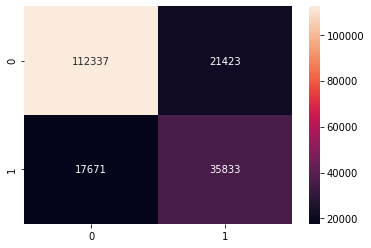

In [44]:
sns.heatmap(confusion_matrix(y_test,lr_pred),annot=True,fmt='d')
plt.show()

In [45]:
print(' Logistic Regression AUC-Score:',roc_auc_score(y_test,lr_prob[:,1]))

 Logistic Regression AUC-Score: 0.8667815866581903


In [46]:
k=KFold(n_splits=10)
score=cross_val_score(lr,X_train,y_train,scoring='f1_weighted',cv=k)
print('Average score:',np.mean(score))
print('Variance error:', np.std(score)/np.mean(score))

Average score: 0.7930382954331507
Variance error: 0.002912794015468851


*As seen in the above result the bias_error is high indicating that our model is still baised(probably towards 'No' Response),on another note the variance_error is comparatively less.*

**Finding  optimal threshold for LogisticRegression using Youden's Index** 

In [47]:
lr_fpr,lr_tpr,lr_thres=roc_curve(y_test,lr_prob[:,1])

In [48]:
youden_df = pd.DataFrame({'TPR':lr_tpr,'FPR':lr_fpr,'Threshold':lr_thres})
youden_df['Difference'] = youden_df['TPR']-youden_df['FPR']

In [49]:
youden_df.sort_values(by='Difference',ascending=False).head(5)

,TPR,FPR,Threshold,Difference
38639,0.870888,0.272279,0.324336,0.598609
38637,0.870832,0.272241,0.324416,0.598591
38638,0.870832,0.272279,0.324360,0.598553
38635,0.870776,0.272234,0.324432,0.598542
38636,0.870776,0.272241,0.324430,0.598535


In [50]:
youden_pred=[0 if i < 0.336236 else 1 for i in lr_prob[:,1]]

In [51]:
print(classification_report(y_test,youden_pred))

              precision    recall  f1-score   support

           0       0.93      0.73      0.82    133760
           1       0.56      0.86      0.68     53504

    accuracy                           0.77    187264
   macro avg       0.75      0.80      0.75    187264
weighted avg       0.83      0.77      0.78    187264



*The Youden threshold didn't yield better accuracy than Logistic regression(based on 'f1-weighted' score)*

## **RANDOM FOREST**

In [53]:
rf=RandomForestClassifier(max_depth=7)#intializing Random Forest

In [54]:
rf_model=rf.fit(X_train,y_train)

In [57]:
score=cross_val_score(rf,X_train,y_train,cv=5)
print('Average score:',np.mean(score))
print('variance error:',np.std(score)/np.mean(score))

Average score: 0.8092732543477835
variance error: 0.0012048446482128125


In [58]:
print('Testing Score:',rf_model.score(X_test,y_test))

Testing Score: 0.8094348086124402


* *The above randomforest model has higher training accuracy and lower testing accuracy ,meaning the model is overfitting the data*
* Here GridSearchCV can be used to find best parameters for Random Forest(I have not done it since it requires high computational power).

## XGBoost

In [59]:
xgb=XGBClassifier()#initializing XGBoost classifier

In [60]:
X_train.head()

,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Gender_Male,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years,Vehicle_Damage_Yes
279276,-0.986107,0.044759,-0.753523,1.296490,-0.383613,1.238526,-0.158450,-1.023621,1.327978,-0.196725,-1.199248
334086,0.095059,0.044759,-0.478318,-0.771313,-0.834408,-1.462305,0.990351,-1.023621,-0.753024,-0.196725,0.833856
410897,-0.040087,0.044759,1.493646,-0.771313,0.662696,-0.029816,-0.541383,-1.023621,-0.753024,-0.196725,-1.199248
275191,-1.323972,0.044759,-0.863445,-0.771313,-0.375645,-1.205988,-0.421716,0.976924,1.327978,-0.196725,0.833856
413420,0.297777,0.044759,-0.761255,-0.771313,0.097886,0.825131,-0.421716,-1.023621,-0.753024,-0.196725,0.833856


In [61]:
#some features names have symbols for which XGB will throw error,hence removing such symbols from feature names
import re

regex = re.compile(r"\[|\]|<", re.IGNORECASE)

X_train.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_train.columns.values]

In [62]:
xgb_model=xgb.fit(X_train,y_train)

[14:01:34] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [63]:
print('Training Score:',xgb_model.score(X_train,y_train))

Training Score: 0.8821797546405405


In [64]:
print('Testing Score:',xgb_model.score(X_test,y_test))

Testing Score: 0.8776753673957621


In [65]:
k=KFold(n_splits=10)
score=cross_val_score(xgb,X_train,y_train,scoring='f1_weighted',cv=k)
print('Bias error:',1-np.mean(score))
print('Variance error:', np.std(score)/np.mean(score))

[14:01:47] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:01:58] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:02:11] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:02:22] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

**The XGBoost model seem to reduces the bias and variance error significantly**

In [66]:
xgb_pred=xgb_model.predict(X_test)
xgb_prob=xgb_model.predict_proba(X_test)

In [67]:
xgb_fpr,xgb_tpr,threshold=roc_curve(y_test,xgb_prob[:,1])

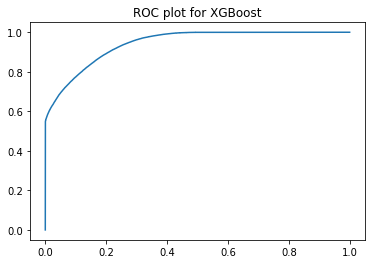

In [68]:
plt.plot(xgb_fpr,xgb_tpr)
plt.title('ROC plot for XGBoost')
plt.show()

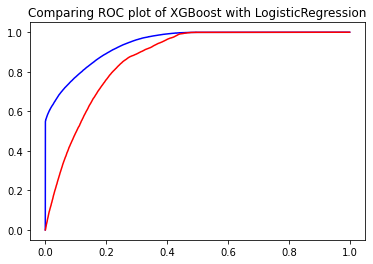

In [82]:
plt.plot(xgb_fpr,xgb_tpr,'b')
plt.plot(lr_fpr,lr_tpr,'r')
plt.title('Comparing ROC plot of XGBoost with LogisticRegression')
plt.show()

*Looking at the above plot,it is clear that the XGBoost model was able to cover more area under the curve than Logistic Regression.*

In [70]:
print('AUC Score:',roc_auc_score(y_test,xgb_prob[:,1]))

AUC Score: 0.9426601627977149


In [71]:
print(classification_report(y_test,xgb_pred))

              precision    recall  f1-score   support

           0       0.87      0.97      0.92    133760
           1       0.89      0.65      0.75     53504

    accuracy                           0.88    187264
   macro avg       0.88      0.81      0.84    187264
weighted avg       0.88      0.88      0.87    187264



*The XGBoost model has significantly increased the model accuracy with 87% accuracy(f1-weighted).*

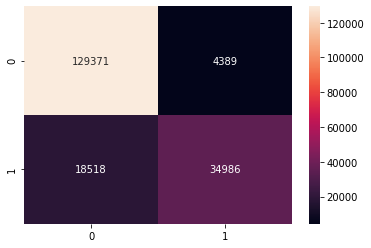

In [72]:
xgb_cfm=confusion_matrix(y_test,xgb_pred)
sns.heatmap(xgb_cfm,annot=True,fmt='d')
plt.show()

## Stacking Classifier

In [73]:
#initializing stacking classifier with 'XGBooost' as final estimator
rf_v=RandomForestClassifier(n_estimators=100,max_depth=12)
gb=GradientBoostingClassifier(n_estimators=50,max_depth=13)
models =[('RandomForest',rf_v),('GB',gb)]
stack = StackingClassifier(estimators=models,final_estimator=xgb,cv=3)

In [74]:
stack_model=stack.fit(X_train,y_train)

[14:10:50] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [75]:
print('Train Score:',stack_model.score(X_train,y_train))

Train Score: 0.8970572529139106


In [76]:
print('Test Score:',stack_model.score(X_test,y_test))

Test Score: 0.8750801008202324


* The test accuracy is slightly lesser than training accuracy,i.e our model is slightly overfitting.
* Again we can use GridSearchCV to find best parameters to improve the model performance(requires high computational power).

In [77]:
stack_pred=stack_model.predict(X_test)
stack_prob=stack_model.predict_proba(X_test)

In [78]:
print(classification_report(y_test,stack_pred))

              precision    recall  f1-score   support

           0       0.87      0.97      0.92    133760
           1       0.90      0.63      0.74     53504

    accuracy                           0.88    187264
   macro avg       0.88      0.80      0.83    187264
weighted avg       0.88      0.88      0.87    187264



In [79]:
stk_fpr,stk_tpr,stk_th=roc_curve(y_test,stack_prob[:,1])

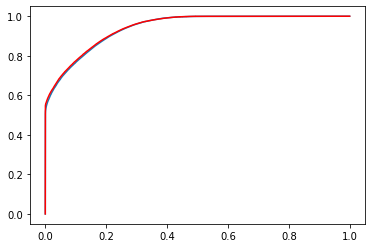

In [80]:
plt.plot(stk_fpr,stk_tpr)
plt.plot(xgb_fpr,xgb_tpr,'r')
plt.show()

In [81]:
print('Auc score for stacking classifier:',roc_auc_score(y_test,stack_prob[:,1]))

Auc score for stacking classifier: 0.940638555977928


 *the stacking and xgboost model have almost similar area under the curve.*

## Conclusion
* Thus the XGBoost Model has the best 'AUC-score' than all the other models.
* The stacking model also has accuracy similar to XGBoost.
* We can also find the best parameters for each models to gain further accuracy by performing Hyper-parameter tuning.